In [1]:
!uv pip install -q --system numba-cuda==0.4.0

In [2]:
import numba.cuda as cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt
import numpy as np


CPU Image processing

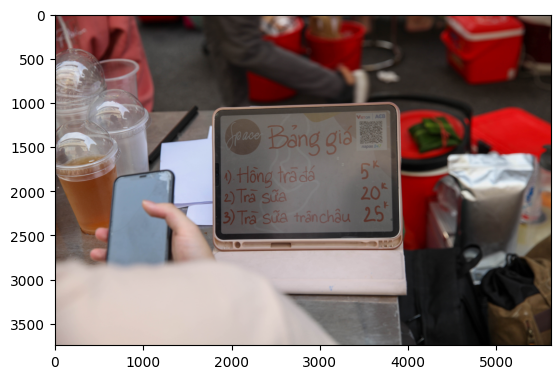

In [3]:
img_path = "/content/drive/MyDrive/IMG_1109.jpg"
img = plt.imread(img_path)
plt.imshow(img)

In [4]:
print(img.shape)
compressed_img = img.reshape(img.shape[0]* img.shape[1], 3)
print(compressed_img.shape)

(3744, 5616, 3)
(21026304, 3)


Grayscale (CPU, From scratch)

In [31]:
import time
r = compressed_img[: ,0]
g = compressed_img[: ,1]
b = compressed_img[:, 2]
gray_img = []
start = time.time()
for r_pixel, g_pixel, b_pixel in zip(r,g,b):
  gray_pixel = ((r_pixel + g_pixel +  b_pixel)/3)
  gray_img.append(gray_pixel)
end = time.time()

print(f"CPU runtime: {end - start}")


/tmp/ipython-input-2012604956.py:8: RuntimeWarning: overflow encountered in scalar add
  gray_pixel = ((r_pixel + g_pixel +  b_pixel)/3)


CPU runtime: 24.939112901687622


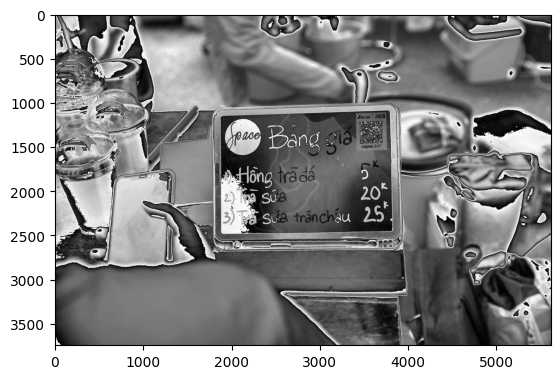

In [32]:
norm_gray_img = compressed_gray_img = np.asanyarray(gray_img, dtype="float32")
gray_img = norm_gray_img.reshape(img.shape[0], img.shape[1], 1)
plt.imshow(gray_img, cmap="gray")

GrayScale (GPU, From Scratch)

In [6]:
compressed_img_cuda = cuda.to_device(compressed_img)
print(compressed_img_cuda.shape)
print(type(compressed_img_cuda))
block_size = 64
pixel_count = img.shape[0] * img.shape[1]
grid_size = int(pixel_count/block_size)

(21026304, 3)
<class 'numba.cuda.cudadrv.devicearray.DeviceNDArray'>


In [7]:
@cuda.jit
def grayscale(src, dst):
# where are we in the input?
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
  dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

CUDA runtime: 0.11200857162475586
(21026304, 1)


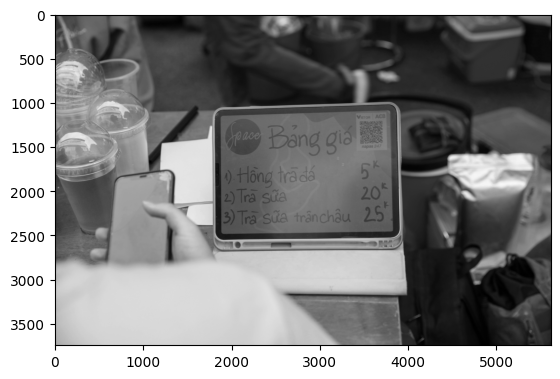

In [35]:
gray_img_cuda =  cuda.device_array((pixel_count, 1), dtype=np.uint8)
start = time.time()
grayscale[grid_size, block_size](compressed_img_cuda, gray_img_cuda)
end = time.time()

gray_img_host = gray_img_cuda.copy_to_host()
print(f"CUDA runtime: {end-start}")
print(gray_img_host.shape)
gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)
plt.imshow(gray_img, cmap="gray")

In [36]:
print(gray_img_host)

[[50]
 [50]
 [50]
 ...
 [25]
 [25]
 [25]]


In [9]:
import time
block_sizes = [2**i for i in range(2,11)]
runtime = []
for block_size in block_sizes:
  block_sizes_runtime = []
  for i in range(1000):
    grid_size = int(pixel_count/block_size)
    gray_img_cuda =  cuda.device_array((pixel_count, 1), dtype=np.uint8)
    start = time.time()
    grayscale[grid_size, block_size](compressed_img_cuda, gray_img_cuda)
    gray_img_host = gray_img_cuda.copy_to_host()
    end = time.time()
    run = end -start
    block_sizes_runtime.append(run)
  runtime.append(sum(block_sizes_runtime)/len(block_sizes_runtime))
  print(f"CUDA runtime: {sum(block_sizes_runtime)/len(block_sizes_runtime)}")
  print(gray_img_host.shape)

CUDA runtime: 0.02086272692680359
(21026304, 1)
CUDA runtime: 0.012724994659423828
(21026304, 1)
CUDA runtime: 0.008653671979904175
(21026304, 1)
CUDA runtime: 0.006807843923568726
(21026304, 1)
CUDA runtime: 0.00683733320236206
(21026304, 1)
CUDA runtime: 0.007290690422058105
(21026304, 1)
CUDA runtime: 0.008023131608963013
(21026304, 1)
CUDA runtime: 0.007413433790206909
(21026304, 1)
CUDA runtime: 0.006977809190750122
(21026304, 1)


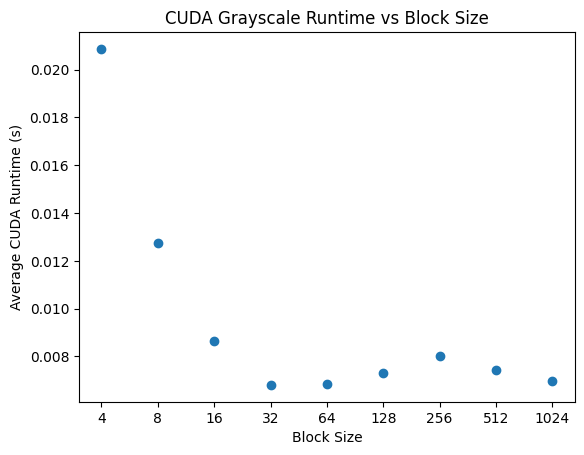

In [10]:
plt.scatter(range(len(block_sizes)), runtime)
plt.xticks(range(len(block_sizes)), block_sizes)
plt.xlabel("Block Size")
plt.ylabel("Average CUDA Runtime (s)")
plt.title("CUDA Grayscale Runtime vs Block Size")
plt.show()
